In [57]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
from meep_material import lorentzfit

In [58]:
resolution = 100
nfreq = 300
fcen = 1.75
df = 3.3

In [59]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                       ):    
        # 1. 데이터 로드 및 전처리,
        data = np.genfromtxt(Material_data_csv, delimiter=",")
        wl = data[:, 0] * 1e6  # 파장 (µm),
        n_data = data[:, 1] + 1j * data[:, 2]
        eps_all = np.square(n_data) - eps_inf
    
        # 피팅 범위로 데이터 선택,
        mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
        wl_fit, eps_fit = wl[mask], eps_all[mask]
        freqs_fit = 1 / wl_fit
    
        # 2. Lorentzian 피팅 최적화,
        ps = np.zeros((iteration, 3 * num_lorentzians))
        errors = np.zeros(iteration)
        for m in range(iteration):
            p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
            ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
            print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
        best = np.argmin(errors)
        print(f"Optimal error: {errors[best]:.6f}")
    
        # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성,
        suscept = []
        for i in range(num_lorentzians):
            freq_param = ps[best][3*i + 1]
            gamma = ps[best][3*i + 2]
            if freq_param == 0:
                sigma = ps[best][3*i + 0]
                suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
            else:
                sigma = ps[best][3*i + 0] / freq_param**2
                suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))
    
        return eps_inf, suscept
    
sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000011
Iteration   1, error: 0.000016
Iteration   2, error: 0.000045
Iteration   3, error: 0.000009
Iteration   4, error: 0.000010
Iteration   5, error: 0.000009
Iteration   6, error: 0.000049
Iteration   7, error: 0.000018
Iteration   8, error: 0.000010
Iteration   9, error: 0.000015
Iteration  10, error: 0.000064
Iteration  11, error: 0.000005
Iteration  12, error: 0.000016
Iteration  13, error: 0.000025
Iteration  14, error: 0.000039
Iteration  15, error: 0.000010
Iteration  16, error: 0.000046
Iteration  17, error: 0.000020
Iteration  18, error: 0.000014
Iteration  19, error: 0.000013
Iteration  20, error: 0.000009
Iteration  21, error: 0.000017
Iteration  22, error: 0.000009
Iteration  23, error: 0.000013
Iteration  24, error: 0.000018
Iteration  25, error: 0.000008
Iteration  26, error: 0.000020
Iteration  27, error: 0.000014
Iteration  28, error: 0.000016
Iteration  29, error: 0.000011
Optimal error: 0.000005
Iteration   0, error: 64.226780
Iteration   1,

In [171]:
# === 설정 ===
resolution = 100
cell_size = mp.Vector3(3, 3, 0)
fcen = 1.75       # Gaussian source 중심 주파수
df = 3.3          # Gaussian source 대역폭
nfreq = 300

field_component = mp.Ex  # 원하는 필드 성분

# === 측정할 파장 범위 (0.4 ~ 0.7 μm) ⇒ 주파수로 변환 ===
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max   # ≈ 1.4286
fmax = 1 / lambda_min   # = 2.5
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# === 소스 위치 ===
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=field_component,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]

pml_layers = [mp.PML(0.3)]


# === 시뮬레이션 ===
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    default_material=mp.Medium(index=1.0),
    sources=sources,
    resolution=resolution
)

offset = 0.01
flux_size = 0.02
source_center = mp.Vector3(0, 0)

x1_air = sim.add_flux(
    fcen_dft, df_dft, nfreq,
    # x1
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size), 
                #   weight=-1
                  ),
)

x2_air = sim.add_flux(
    fcen_dft, df_dft, nfreq,
    # x2
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size)),
)

y1_air = sim.add_flux(
    fcen_dft, df_dft, nfreq,
    # y1
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0), 
                #   weight=-1
                  ),
)

y2_air = sim.add_flux(
    fcen_dft, df_dft, nfreq,
    # y2
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0))
)   
    


sim.run(until=50)

P_x1_air = mp.get_fluxes(x1_air)
P_x2_air = mp.get_fluxes(x2_air)
P_y1_air = mp.get_fluxes(y1_air)
P_y2_air = mp.get_fluxes(y2_air)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000138998 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.0503681 s
-----------
run 0 finished at t = 50.0 (10000 timesteps)


In [172]:
### ----- Refractive index ----- ###,
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

# Cathode = mp.perfect_electric_conductor,

CoverLayer = mp.Medium(index=1.9) # SiN ,
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

Absorber_layer = 0.5

boundary_layers = [
    mp.PML(thickness=Absorber_layer, direction=mp.X, side=mp.Low),  # 좌측 PML,
    mp.PML(thickness=Absorber_layer, direction=mp.X, side=mp.High), # 우측 PML,
    mp.PML(thickness=Absorber_layer, direction=mp.Y, side=mp.High), # 상단 PML,
]

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [173]:
cell_size = mp.Vector3(31, 2, 0)

geometry_fitting_Al = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 0),
            material=Cathode
        ),
        # # Alq3
        # mp.Block(
        #     center=Alq3_center,
        #     size=mp.Vector3(mp.inf, Alq3_layer, 0),
        #     material=Alq3
        # ),
        # # aNDP
        # mp.Block(
        #     center=aNDP_center,
        #     size=mp.Vector3(mp.inf, aNDP_layer, 0),
        #     material=aNDP
        # ),
        # # ITO
        # mp.Block(
        #     center=ITO_center,
        #     size=mp.Vector3(mp.inf, ITO_layer, 0),
        #     material=ITO_m
        # ),
        # # Cover layer
        # mp.Block(
        #     center=Cover_center,
        #     size=mp.Vector3(mp.inf, Cover_layer, 0),
        #     material=CoverLayer
        # ),
        # # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        # mp.Block(
        #     center=Glass_center,
        #     size=mp.Vector3(mp.inf, Glass_layer, 0),
        #     material=Glass
        # )
]

source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0)
)]

In [174]:
# === 시뮬레이션 설정 === #
sim_fitting_Al = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting_Al,
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
)

In [134]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting_Al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting_Al.run(until = 50)
net_power_fitting_al = mp.get_fluxes(box_power_fitting_Al)

-----------
Initializing structure...
time for choose_chunkdivision = 1.88351e-05 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.429521 s
time for set_conductivity = 0.0125329 s
time for set_conductivity = 0.012543 s
time for set_conductivity = 0.0125899 s
time for set_conductivity = 0.0128911 s
time for set_conductivity = 0.012651 s
time for set_conductivity = 0.0125611 s
lorentzian susceptibility: frequency=1.01629, gamma=0.899161
drude susceptibility: frequency=1, gamma=0
-----------
Meep progress: 2.575/50.0 = 5.2% done in 4.0s, 73.7s to go
on time step 515 (time=2.575), 0.00777454 s/step
Meep progress: 5.555/50.0 = 11.1% done in 8.0s, 64.1s to go
on time step 1111 (time=5.555), 0.00671789 s/step
Meep progress: 8.595/50.0 = 17.2% done in 12.0s, 57.8s to go
on time st

In [175]:
# 박스 4면
x1_al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        # weight=-1
    ),
)

x2_al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
)

y1_al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        # weight=-1
    ),
)

y2_al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)

sim_fitting_Al.run(until = 50)

P_x1_al = mp.get_fluxes(x1_al)
P_x2_al = mp.get_fluxes(x2_al)
P_y1_al = mp.get_fluxes(y1_al)
P_y2_al = mp.get_fluxes(y2_al)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000347853 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.441865 s
lorentzian susceptibility: frequency=1.01629, gamma=0.899161
drude susceptibility: frequency=1, gamma=0
-----------
Meep progress: 3.08/50.0 = 6.2% done in 4.0s, 61.0s to go
on time step 616 (time=3.08), 0.00649862 s/step
Meep progress: 6.15/50.0 = 12.3% done in 8.0s, 57.1s to go
on time step 1230 (time=6.15), 0.00651852 s/step
Meep progress: 9.39/50.0 = 18.8% done in 12.0s, 51.9s to go
on time step 1878 (time=9.39), 0.00618038 s/step
Meep progress: 13.09/50.0 = 26.2% done in 16.0s, 45.2s to go
on time step 2618 (time=13.09), 0.00540557 s/step
Meep progress: 16.63/50.0 = 33.3% done in 20.0s, 40.2s to go
on time step 3326 (time=16.63), 

In [176]:
norm_x1 = np.array(P_x1_al) / np.array(P_x1_air)
norm_x2 = np.array(P_x2_al) / np.array(P_x2_air)
norm_y1 = np.array(P_y1_al) / np.array(P_y1_air)
norm_y2 = np.array(P_y2_al) / np.array(P_y2_air)

net_norm = norm_x1+norm_x2+norm_y1+norm_y2

     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

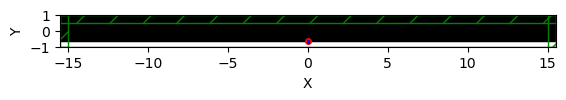

In [169]:
sim_fitting_Al.plot2D()

In [154]:
frequencies = mp.get_flux_freqs(box_power_fitting_Al)

wavelengths = [1/f for f in frequencies]

print("λ (μm) dipolepower_box (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f} {net_power_fitting_al[i]:.6e}")

λ (μm) dipolepower_box (W)
0.7000 3.366200e-03
0.6982 3.424576e-03
0.6965 3.483750e-03
0.6948 3.542715e-03
0.6930 3.601294e-03
0.6913 3.660327e-03
0.6896 3.720790e-03
0.6879 3.782775e-03
0.6862 3.845431e-03
0.6845 3.907893e-03
0.6829 3.970215e-03
0.6812 4.033277e-03
0.6795 4.097793e-03
0.6779 4.163501e-03
0.6763 4.229434e-03
0.6746 4.294995e-03
0.6730 4.360653e-03
0.6714 4.427488e-03
0.6698 4.496044e-03
0.6682 4.565712e-03
0.6666 4.635339e-03
0.6650 4.704417e-03
0.6634 4.773614e-03
0.6618 4.844062e-03
0.6603 4.916176e-03
0.6587 4.989251e-03
0.6571 5.062258e-03
0.6556 5.134961e-03
0.6541 5.208145e-03
0.6525 5.282726e-03
0.6510 5.358709e-03
0.6495 5.435156e-03
0.6480 5.511214e-03
0.6465 5.587080e-03
0.6450 5.663842e-03
0.6435 5.742335e-03
0.6420 5.822226e-03
0.6406 5.902331e-03
0.6391 5.981834e-03
0.6376 6.061137e-03
0.6362 6.141418e-03
0.6347 6.223382e-03
0.6333 6.306534e-03
0.6318 6.389742e-03
0.6304 6.472465e-03
0.6290 6.555322e-03
0.6276 6.639380e-03
0.6262 6.724961e-03
0.6248 6.8112

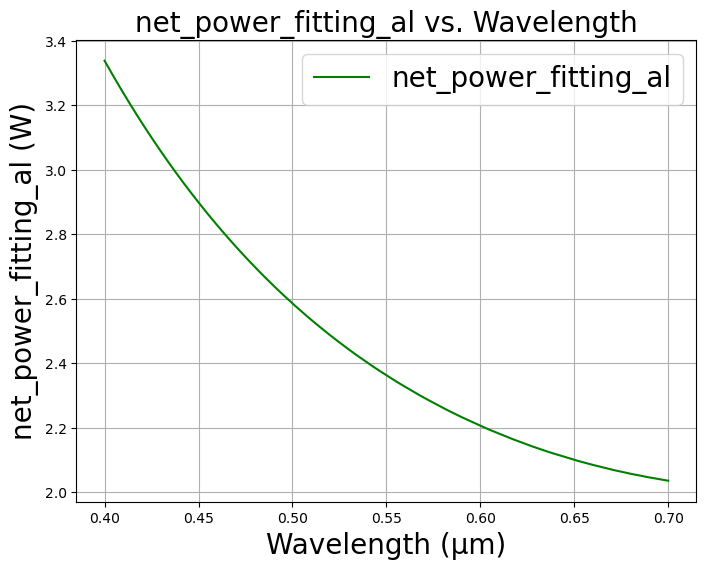

In [177]:
plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_norm, '-', label='net_power_fitting_al', color = 'green')
plt.xlabel('Wavelength (μm)', fontsize = 20)
plt.ylabel('net_power_fitting_al (W)', fontsize = 20)
plt.title('net_power_fitting_al vs. Wavelength', fontsize = 20)

plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

In [139]:
import numpy as np

# CSV 파일 불러오기
data = np.genfromtxt("dipole_power.csv", delimiter=",")

# 데이터 분리
wavelengths = data[:, 0]
source_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths >= 0) & (wavelengths <= 10)
wavelength_sliced = wavelengths
power_sliced = source_power

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced)
print("슬라이싱된 power:", power_sliced)

슬라이싱된 wavelength: [0.7        0.69824854 0.69650582 0.69477178 0.69304636 0.69132948
 0.68962109 0.68792112 0.68622951 0.6845462  0.68287113 0.68120423
 0.67954545 0.67789474 0.67625202 0.67461724 0.67299035 0.67137129
 0.66976    0.66815642 0.66656051 0.6649722  0.66339144 0.66181818
 0.66025237 0.65869394 0.65714286 0.65559906 0.6540625  0.65253313
 0.65101089 0.64949573 0.64798762 0.64648649 0.6449923  0.643505
 0.64202454 0.64055088 0.63908397 0.63762376 0.63617021 0.63472328
 0.6332829  0.63184906 0.63042169 0.62900075 0.62758621 0.62617801
 0.62477612 0.62338049 0.62199108 0.62060786 0.61923077 0.61785978
 0.61649485 0.61513593 0.61378299 0.61243599 0.61109489 0.60975965
 0.60843023 0.6071066  0.60578871 0.60447653 0.60317003 0.60186916
 0.60057389 0.59928418 0.598      0.59672131 0.59544808 0.59418027
 0.59291785 0.59166078 0.59040903 0.58916256 0.58792135 0.58668535
 0.58545455 0.58422889 0.58300836 0.58179291 0.58058252 0.57937716
 0.5781768  0.57698139 0.57579092 0.57460535 0

In [140]:
# CSV 파일 불러오기
data = np.genfromtxt("Only_Al.csv", delimiter=",")

# 데이터 분리
wavelengths_Only_al = data[:, 0] * 1e6
Al_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths_Only_al >= 0) & (wavelengths_Only_al <= 10)
wavelength_sliced_al = wavelengths_Only_al
Al_power_sliced = Al_power

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced_al)
print("슬라이싱된 power:", Al_power_sliced)

슬라이싱된 wavelength: [0.7      0.698249 0.696506 0.694772 0.693046 0.691329 0.689621 0.687921
 0.68623  0.684546 0.682871 0.681204 0.679545 0.677895 0.676252 0.674617
 0.67299  0.671371 0.66976  0.668156 0.666561 0.664972 0.663391 0.661818
 0.660252 0.658694 0.657143 0.655599 0.654063 0.652533 0.651011 0.649496
 0.647988 0.646486 0.644992 0.643505 0.642025 0.640551 0.639084 0.637624
 0.63617  0.634723 0.633283 0.631849 0.630422 0.629001 0.627586 0.626178
 0.624776 0.62338  0.621991 0.620608 0.619231 0.61786  0.616495 0.615136
 0.613783 0.612436 0.611095 0.60976  0.60843  0.607107 0.605789 0.604477
 0.60317  0.601869 0.600574 0.599284 0.598    0.596721 0.595448 0.59418
 0.592918 0.591661 0.590409 0.589163 0.587921 0.586685 0.585455 0.584229
 0.583008 0.581793 0.580583 0.579377 0.578177 0.576981 0.575791 0.574605
 0.573425 0.572249 0.571078 0.569912 0.56875  0.567593 0.566441 0.565294
 0.564151 0.563013 0.561879 0.56075  0.559626 0.558506 0.55739  0.556279
 0.555172 0.55407  0.552972 0.5518

In [141]:
# CSV 파일 불러오기
data = np.genfromtxt("dipolepower_nofunc.csv", delimiter=",")

# 데이터 분리
wavelengths_Only_al_func = data[:, 0] * 1e6
Al_power_func = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths_Only_al >= 0) & (wavelengths_Only_al <= 10)
wavelength_sliced_al_nofunc = wavelengths_Only_al_func
Al_power_sliced_nofunc = Al_power_func

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced_al_nofunc)
print("슬라이싱된 power:", Al_power_sliced_nofunc)

슬라이싱된 wavelength: [0.7      0.698249 0.696506 0.694772 0.693046 0.691329 0.689621 0.687921
 0.68623  0.684546 0.682871 0.681204 0.679545 0.677895 0.676252 0.674617
 0.67299  0.671371 0.66976  0.668156 0.666561 0.664972 0.663391 0.661818
 0.660252 0.658694 0.657143 0.655599 0.654063 0.652533 0.651011 0.649496
 0.647988 0.646486 0.644992 0.643505 0.642025 0.640551 0.639084 0.637624
 0.63617  0.634723 0.633283 0.631849 0.630422 0.629001 0.627586 0.626178
 0.624776 0.62338  0.621991 0.620608 0.619231 0.61786  0.616495 0.615136
 0.613783 0.612436 0.611095 0.60976  0.60843  0.607107 0.605789 0.604477
 0.60317  0.601869 0.600574 0.599284 0.598    0.596721 0.595448 0.59418
 0.592918 0.591661 0.590409 0.589163 0.587921 0.586685 0.585455 0.584229
 0.583008 0.581793 0.580583 0.579377 0.578177 0.576981 0.575791 0.574605
 0.573425 0.572249 0.571078 0.569912 0.56875  0.567593 0.566441 0.565294
 0.564151 0.563013 0.561879 0.56075  0.559626 0.558506 0.55739  0.556279
 0.555172 0.55407  0.552972 0.5518

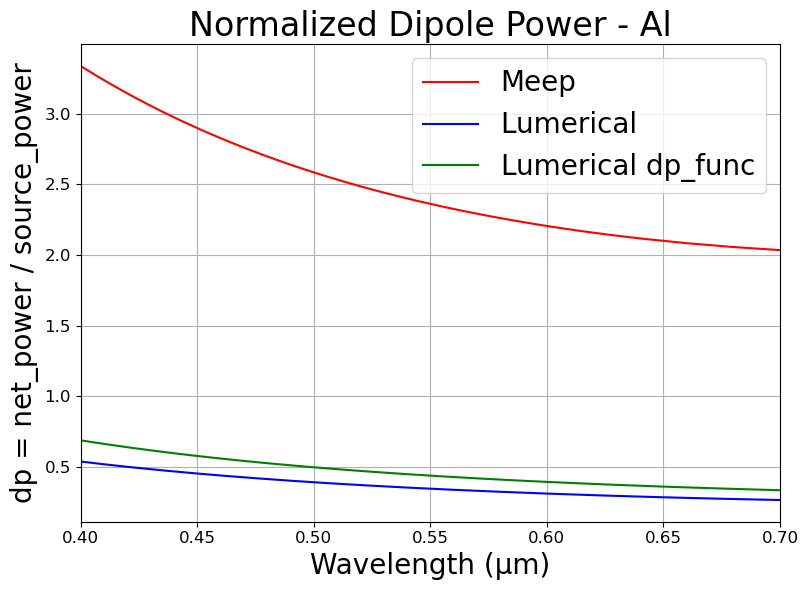

In [157]:
dp_fitting_al = net_power_fitting_al / power_sliced

plt.figure(figsize=(8, 6))

# plot 순서
plt.plot(wavelengths, net_norm, label='Meep', color='red')
plt.plot(wavelength_sliced_al, Al_power_sliced, label='Lumerical ', color='blue')
plt.plot(wavelength_sliced_al_nofunc, Al_power_sliced_nofunc, label='Lumerical dp_func', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power - Al", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
# plt.ylim([0, 1.5])
plt.xlim([0.4, 0.7])
plt.show()

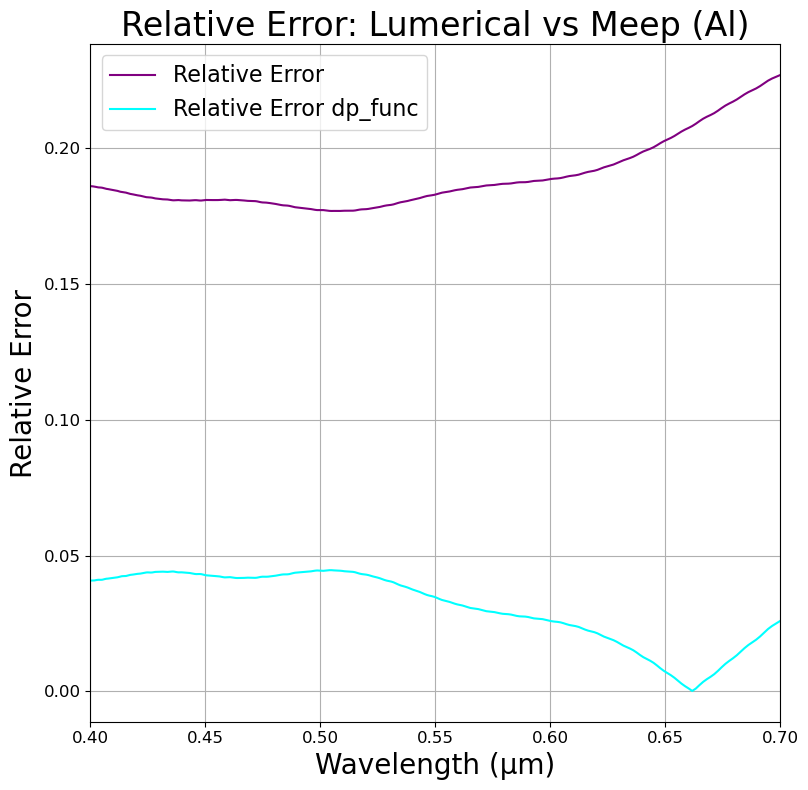

In [143]:
# === Relative Error 계산 === #
relative_error = np.abs((Al_power_sliced - dp_fitting_al) / dp_fitting_al)
relative_error_nofunc = np.abs((Al_power_sliced_nofunc - dp_fitting_al) / dp_fitting_al)


# === Relative Error 플롯 === #
plt.figure(figsize=(8, 8))
plt.plot(wavelengths, relative_error, label='Relative Error', color='purple')
plt.plot(wavelengths, relative_error_nofunc, label='Relative Error dp_func', color='cyan')


# 축 레이블
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error", fontsize=20)

# 제목
plt.title("Relative Error: Lumerical vs Meep (Al)", fontsize=24)

# 눈금, 범례
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlim([0.4, 0.7])
plt.show()
